In [1]:
# A Template NEMS Script suitable for beginners
# Please see docs/architecture.svg for a visual diagram of this code

import logging
import pickle
from pathlib import Path
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nems0.analysis.api
import nems0.initializers
import nems0.preprocessing as preproc
import nems0.uri
from nems0 import db
from nems0 import xforms
from nems0 import recording
from nems0.fitters.api import scipy_minimize
from nems0.signal import RasterizedSignal
from nems import Model

log = logging.getLogger(__name__)

# CONFIGURATION

# figure out data and results paths:
signals_dir = Path(nems0.NEMS_PATH) / 'recordings'
modelspecs_dir = Path(nems0.NEMS_PATH) / 'modelspecs'

In [12]:
def plot_binaural_model(model, X_val, Y_val=None):
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    if Y_val is None:
        cc=0
        nmse=1
    else:
        cc = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
        nmse = np.std(prediction-Y_val) / np.std(Y_val)

    wc = model.layers[0].coefficients
    fir = model.layers[1].coefficients

    if len(wc.shape)>2:
        strf=wc[:,:,0] @ fir[:,:,0].T
        if wc.shape[2]>1:
            strf2=wc[:,:,1] @ fir[:,:,1].T
        else:
            strf2=strf.copy()
    elif len(fir.shape)>2:
        strf=wc @ fir[:,:,0].T
        if fir.shape[2]>1:
            strf2=wc @ fir[:,:,1].T
        else:
            strf2 = strf.copy()
    else:
        strf=wc @ fir.T
        strf2 = strf.copy()
    strf *= model.layers[2].coefficients[0]
    strf2 *= model.layers[2].coefficients[1]
    cmax=np.max([np.abs(strf).max(), np.abs(strf2).max()])

    fig=plt.figure()
    spec = fig.add_gridspec(3, 4)

    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, :])
    ax20 = fig.add_subplot(spec[2, 0])
    ax21 = fig.add_subplot(spec[2, 1])
    ax22 = fig.add_subplot(spec[2, 2:])
    
    bins=550
    b0=0
    b1=b0+bins
    fs=100
    dur=bins/fs
    chans = X_val.shape[1]
    t=np.linspace(0,dur,bins)
    _x = np.reshape(np.transpose(X_val[b0:b1,:,:],[0,2,1]),(bins,-1)).T
    ax0.imshow(_x, aspect='auto', extent=[0,dur,-0.5,chans+0.5])
    ax0.set_title(f"{model.name} cc={cc:.3f} nmse={nmse:.3f}")
    if Y_val is not None:
        ax1.plot(t,Y_val[b0:b1,0])
    ax1.plot(t,prediction[b0:b1,0])
    ax1.set_xlim(ax0.get_xlim())
    ax20.imshow(strf, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])
    ax21.imshow(strf2, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])

    xin = model.evaluate(input=X_val, n=len(model.layers)-2)['_last_output']
    xrange = np.linspace(xin.min(),xin.max(),100)[:,np.newaxis]
    xout = model.layers[-1].evaluate(xrange)
    if Y_val is not None:
        ax22.plot(xin[:,0],Y_val[:,0],'.', markersize=2, color='lightgray')
    ax22.plot(xrange[:,0],xout[:,0], color='k')


In [3]:
def plot_binaural_layers(model, X_val, Y_val=None):
    x1 = model.evaluate(input=X_val, n=0)['_last_output']
    x2 = model.evaluate(input=X_val, n=1)['_last_output']
    x3 = model.evaluate(input=X_val, n=2)['_last_output']
    x4 = model.evaluate(input=X_val, n=3)['output']

    f,ax = plt.subplots(6,1, sharex=True)

    ax[0].imshow(X_val[:1000,:,0].T, aspect='auto', interpolation='none')
    ax[0].set_ylabel('stim 0')

    ax[1].imshow(X_val[:1000,:,1].T, aspect='auto', interpolation='none')
    ax[1].set_ylabel('stim 1')

    ax[2].plot(x1[:1000,:,0])
    ax[2].plot(x1[:1000,:,1], '--')
    ax[2].set_ylabel('wc1 output')

    ax[3].plot(x2[:1000,0])
    ax[3].plot(x2[:1000,1], '--')
    ax[3].set_ylabel('fir output')

    ax[4].plot(x3[:1000,:])
    ax[4].set_ylabel('wc1 output')

    ax[5].plot(x4[:1000,:])
    if Y_val is not None:
        ax[5].plot(Y_val[:1000,0])
    ax[5].set_ylabel('dexp output')

In [4]:
def simulate_binaural(X, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=False):
    
    models = Model.from_keywords(modelspec)
    wc=models.layers[0].coefficients
    wc[:] = 0
    #wc[4,1,0] = 0.5
    #wc[5,1,0] = -0.5
    wc[7,0,1] = 1
    wc[8,0,1] = 0.5
    models.layers[0]['coefficients'] = wc

    fir=models.layers[1].coefficients
    fir[:] = 0
    fir[1,1,0] = 1
    fir[2,1,0] = 1
    fir[1,0,1] = 1
    fir[2,0,1] = 0.5
    models.layers[1]['coefficients'] = fir

    wc2=models.layers[2].coefficients
    wc2[:]= 0
    wc2[0] = 1
    wc2[1] = 1
    models.layers[2]['coefficients']=wc2
    
    Y = models.predict(X)
    Y = Y + np.random.randn(len(Y),1)/Y.std()*0.05
    if verbose:
        plot_binaural_model(models, X, Y_val=Y)
    
    return Y

In [5]:
batch=338
modelname="gtgram.fs100.ch18.mono-ld.pop-norm.l1-sev_wc.Nx60-fir.1x20x60-wc.60xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
# raw binaural model
#recording_uri = '/auto/data/nems_db/recordings/338/CLT041c_c6cec16ea49389fffff3880d5742bfc3a3cf4924.tgz'
recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_dd50ace1b2f07b2fa485d44fa09f5908ca222e0d.tgz'
rec = recording.load_recording(recording_uri)

# "HRTF" binaural model
recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_03fad55eb0b91a734d800a85ad3a78ae790c7d36.tgz'
rec_hrtf = recording.load_recording(recording_uri)

rec['stim_hrtf'] = rec_hrtf['stim']

ctx = {'rec': rec}
ctx.update(xforms.normalize_sig(sig='resp', norm_method='minmax', **ctx))
ctx.update(xforms.normalize_sig(sig='stim', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.normalize_sig(sig='stim_hrtf', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.split_by_occurrence_counts(epoch_regex='^STIM', **ctx))
ctx.update(xforms.average_away_stim_occurrences(epoch_regex='^STIM', **ctx))

[nems0.xforms INFO] xforms.normalize_sig(minmax): resp b=0.0, g=3.8181818181818183, dlog(..., -None)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim b=0.0, g=5.311554912564187, dlog(..., -1)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim_hrtf b=0.0, g=5.1749485177800185, dlog(..., -1)


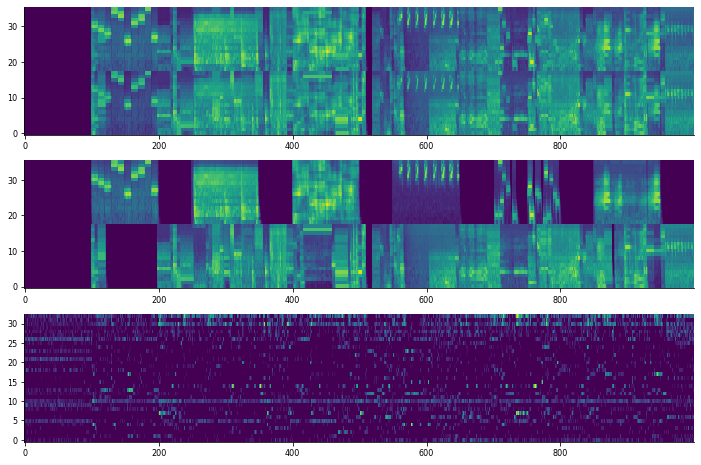

In [6]:
X_all_h = ctx['val']['stim_hrtf'].as_continuous()
X_all = ctx['val']['stim'].as_continuous()
Y_all = ctx['val']['resp'].as_continuous()
f,ax = plt.subplots(3,1, figsize=(12,8))
ax[0].imshow(X_all_h[:,:1000], aspect='auto', interpolation='none', origin='lower')
ax[1].imshow(X_all[:,:1000], aspect='auto', interpolation='none', origin='lower')
ax[2].imshow(Y_all[:,:1000], aspect='auto', interpolation='none', origin='lower')

In [7]:
# testing binaural NAT with various model architectures.
cellids = [rec['resp'].chans[6]]
cellids = [rec['resp'].chans[19]]
cellids = [rec['resp'].chans[30]]
cellids = [rec['resp'].chans[10]]
cellids = [rec['resp'].chans[4]]

print("cellids: ", cellids)

X_est_h = ctx['est']['stim_hrtf'].as_continuous().T.copy()
X_est = ctx['est']['stim'].as_continuous().T.copy()
Y_est = ctx['est']['resp'].extract_channels(cellids).as_continuous().T
X_val_h = ctx['val']['stim_hrtf'].as_continuous().T.copy()
X_val = ctx['val']['stim'].as_continuous().T.copy()
Y_val = ctx['val']['resp'].extract_channels(cellids).as_continuous().T

X_norm = X_est.max()
X_est_h /= X_norm
X_est /= X_norm
X_val_h /= X_norm
X_val /= X_norm

if True:
    # binaural STRF
    X_est_h=np.swapaxes(np.reshape(X_est_h, [-1, 2, 18]), 2, 1)
    X_est=np.swapaxes(np.reshape(X_est, [-1, 2, 18]), 2, 1)
    X_val_h=np.swapaxes(np.reshape(X_val_h, [-1, 2, 18]), 2, 1)
    X_val=np.swapaxes(np.reshape(X_val, [-1, 2, 18]), 2, 1)

    # shorten est data for speed
    #X_est_h = X_est_h[:150000, :, :]
    #X_est = X_est[:150000, :, :]
    #Y_est = Y_est[:150000, :]

    modelspec = 'wc.18x3x1.b-fir.15x3x1-wc.2x1-dexp.1'
    modelspec = 'wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s'
    modelspec = 'wc.18x2x2.b-fir.15x2x2-wc.2x1-dexp.1'
else:
    modelspec = 'wc.36x2-fir.15x2-dexp.1'

    # shorten est data for speed
    X_est_h = X_est_h[:50000, :]
    X_est = X_est[:50000, :]
    Y_est = Y_est[:50000, :]

cellids:  ['CLT039c-016-1']


In [8]:
X_est_h.shape

(396000, 18, 2)

## Simulate specific tuning

In [13]:
simulate=False
if simulate:
    print('simulating response vectors')
    Y_est = simulate_binaural(X_est_h, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=False)
    Y_val = simulate_binaural(X_val_h, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=True)

## Initialize model, plot initialized model

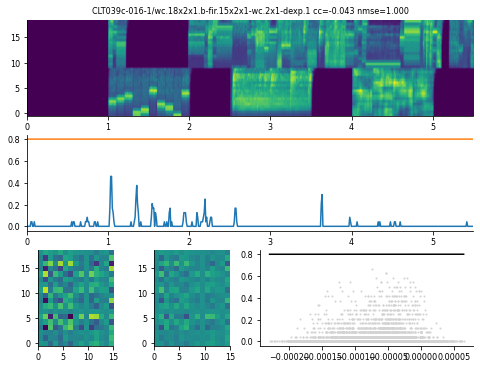

In [14]:
modelspec = 'wc.18x2x1.b-fir.15x2x1-wc.2x1-dexp.1'
model0 = Model.from_keywords(modelspec)
model0.name = f"{cellids[0]}/{modelspec}"

# Set initial values
# quick & dirty, but may not work as desired
model0 = model0.sample_from_priors()
model0 = model0.sample_from_priors()
#model0 = model0.sample_from_priors()

plot_binaural_model(model0, X_val, Y_val=Y_val)

## Fit with TF backend

In [16]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 
                  'early_stopping_patience': 10,
                  'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
                  'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model = model0.copy()
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est_h, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

fitter_options['early_stopping_tolerance'] = 1e-4
fitter_options['learning_rate'] = 1e-3
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est_h, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

2022-09-07 13:32:37.334457: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 13:32:37.964978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6089 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


1 Physical GPUs, 1 Logical GPUs
TF model built...
Model: "CLT039c-016-1/wc.18x2x1.b-fir.15x2x1-wc.2x1-dexp.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 396000, 18, 2)]   0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 396000, 2, 2)      36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 396000, 2)        30        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 396000, 1)         2         
                                                                 
 dexp (StaticNonlinearityTF)  (None, 396000, 1)        4         
                                                                 
Total params: 72
Trainable param

2022-09-07 13:32:39.062951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-09-07 13:32:39.066540: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 13:32:39.068978: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 1/2000
1/1 [==============================] - 1s 582ms/step - loss: 5.4620
Epoch 2/2000
1/1 [==============================] - 0s 54ms/step - loss: 5.3789
Epoch 3/2000
1/1 [==============================] - 0s 55ms/step - loss: 5.2981
Epoch 4/2000
1/1 [==============================] - 0s 57ms/step - loss: 5.2164
Epoch 5/2000
1/1 [==============================] - 0s 53ms/step - loss: 5.1346
Epoch 6/2000
1/1 [==============================] - 0s 53ms/step - loss: 5.0531
Epoch 7/2000
1/1 [==============================] - 0s 52ms/step - loss: 4.9718
Epoch 8/2000
1/1 [==============================] - 0s 49ms/step - loss: 4.8905
Epoch 9/2000
1/1 [==============================] - 0s 45ms/step - loss: 4.8092
Epoch 10/2000
1/1 [==============================] - 0s 50ms/step - loss: 4.7278
Epoch 11/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.6457
Epoch 12/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.5619
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 52ms/step - loss: 1.0100
Epoch 103/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0085
Epoch 104/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0072
Epoch 105/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0060
Epoch 106/2000
1/1 [==============================] - 0s 50ms/step - loss: 1.0048
Epoch 107/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0037
Epoch 108/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0027
Epoch 109/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0018
Epoch 110/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.0010
Epoch 111/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0002
Epoch 112/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9994
Epoch 113/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9988
Epoch 114/2000
1/1 [===========

1/1 [==============================] - 0s 50ms/step - loss: 4.4452
Epoch 41/2000
1/1 [==============================] - 0s 47ms/step - loss: 4.3985
Epoch 42/2000
1/1 [==============================] - 0s 48ms/step - loss: 4.3518
Epoch 43/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.3050
Epoch 44/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.2581
Epoch 45/2000
1/1 [==============================] - 0s 49ms/step - loss: 4.2112
Epoch 46/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.1641
Epoch 47/2000
1/1 [==============================] - 0s 49ms/step - loss: 4.1168
Epoch 48/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.0694
Epoch 49/2000
1/1 [==============================] - 0s 51ms/step - loss: 4.0217
Epoch 50/2000
1/1 [==============================] - 0s 50ms/step - loss: 3.9737
Epoch 51/2000
1/1 [==============================] - 0s 51ms/step - loss: 3.9255
Epoch 52/2000
1/1 [=======================

1/1 [==============================] - 0s 51ms/step - loss: 1.1582
Epoch 141/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.1543
Epoch 142/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1504
Epoch 143/2000
1/1 [==============================] - 0s 49ms/step - loss: 1.1466
Epoch 144/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1428
Epoch 145/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.1391
Epoch 146/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.1355
Epoch 147/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.1319
Epoch 148/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.1284
Epoch 149/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.1250
Epoch 150/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.1217
Epoch 151/2000
1/1 [==============================] - 0s 54ms/step - loss: 1.1185
Epoch 152/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 1.0009
Epoch 241/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0006
Epoch 242/2000
1/1 [==============================] - 0s 51ms/step - loss: 1.0004
Epoch 243/2000
1/1 [==============================] - 0s 52ms/step - loss: 1.0001
Epoch 244/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9998
Epoch 245/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9995
Epoch 246/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9993
Epoch 247/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9990
Epoch 248/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9988
Epoch 249/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9986
Epoch 250/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.9983
Epoch 251/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9981
Epoch 252/2000
1/1 [===========

1/1 [==============================] - 0s 48ms/step - loss: 0.9903
Epoch 341/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9902
Epoch 342/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9902
Epoch 343/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9902
Epoch 344/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9901
Epoch 345/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.9901
Epoch 346/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9901
Epoch 347/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9901
Epoch 348/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9900
Epoch 349/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9900
Epoch 350/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9900
Epoch 351/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9900
Epoch 352/2000
1/1 [===========

1/1 [==============================] - 0s 49ms/step - loss: 0.9885
Epoch 441/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9885
Epoch 442/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9885
Epoch 443/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9885
Epoch 444/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9884
Epoch 445/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9884
Epoch 446/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.9884
Epoch 447/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9884
Epoch 448/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9884
Epoch 449/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9884
Epoch 450/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9884
Epoch 451/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9884
Epoch 452/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.9870
Epoch 541/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9870
Epoch 542/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9869
Epoch 543/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9869
Epoch 544/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9869
Epoch 545/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9869
Epoch 546/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9869
Epoch 547/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9868
Epoch 548/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9868
Epoch 549/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9868
Epoch 550/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9868
Epoch 551/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9867
Epoch 552/2000
1/1 [===========

1/1 [==============================] - 0s 49ms/step - loss: 0.9839
Epoch 641/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9839
Epoch 642/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9839
Epoch 643/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9838
Epoch 644/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9838
Epoch 645/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.9837
Epoch 646/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9837
Epoch 647/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9836
Epoch 648/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9836
Epoch 649/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9836
Epoch 650/2000
1/1 [==============================] - 0s 45ms/step - loss: 0.9835
Epoch 651/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9835
Epoch 652/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.9792
Epoch 741/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9792
Epoch 742/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9791
Epoch 743/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9791
Epoch 744/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9791
Epoch 745/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9790
Epoch 746/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9790
Epoch 747/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9789
Epoch 748/2000
1/1 [==============================] - 0s 45ms/step - loss: 0.9789
Epoch 749/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9788
Epoch 750/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9788
Epoch 751/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9788
Epoch 752/2000
1/1 [===========

1/1 [==============================] - 0s 53ms/step - loss: 0.9761
Epoch 841/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9761
Epoch 842/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9761
Epoch 843/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9761
Epoch 844/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9760
Epoch 845/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9760
Epoch 846/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9760
Epoch 847/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9760
Epoch 848/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9760
Epoch 849/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9759
Epoch 850/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9759
Epoch 851/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9759
Epoch 852/2000
1/1 [===========

1/1 [==============================] - 0s 50ms/step - loss: 0.9742
Epoch 941/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9742
Epoch 942/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9742
Epoch 943/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9741
Epoch 944/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9741
Epoch 945/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9741
Epoch 946/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9741
Epoch 947/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9741
Epoch 948/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9741
Epoch 949/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9740
Epoch 950/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9740
Epoch 951/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9740
Epoch 952/2000
1/1 [===========

1/1 [==============================] - 0s 50ms/step - loss: 0.9726
Epoch 1040/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9726
Epoch 1041/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9726
Epoch 1042/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9726
Epoch 1043/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9726
Epoch 1044/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9726
Epoch 1045/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9726
Epoch 1046/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9725
Epoch 1047/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.9725
Epoch 1048/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9725
Epoch 1049/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9725
Epoch 1050/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9725
Epoch 1051/2000
1/1 

1/1 [==============================] - 0s 52ms/step - loss: 0.9715
Epoch 1138/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1139/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1140/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1141/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1142/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1143/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1144/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1145/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9714
Epoch 1146/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9714
Epoch 1147/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9714
Epoch 1148/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9713
Epoch 1149/2000
1/1 

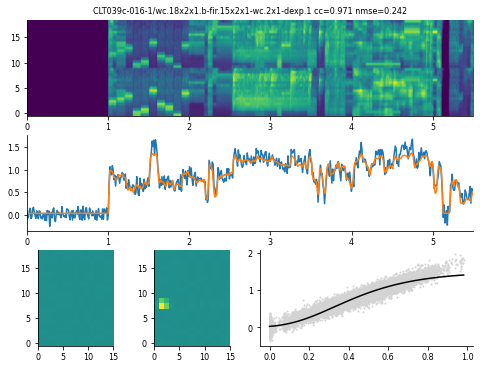

In [21]:
plot_binaural_model(model, X_val_h, Y_val=Y_val)

In [24]:
model.layers[0].coefficients[:,:,0]

array([[ 1.13782408e-02,  8.91905371e-03],
       [ 7.83610642e-02, -6.38536215e-02],
       [-1.03124812e-01,  9.17834342e-02],
       [ 7.58306356e-03,  4.33162879e-03],
       [-1.47493766e-03, -5.23210922e-03],
       [-9.18502584e-02,  3.83814834e-02],
       [-6.11644378e-03,  3.18959402e-03],
       [ 9.15213406e-01,  8.12247157e-01],
       [ 4.70096409e-01,  4.26342815e-01],
       [ 5.46733402e-02, -7.31061772e-02],
       [-1.31379580e-02, -1.14561170e-02],
       [ 2.90159788e-03, -3.39939147e-02],
       [-3.66584398e-02,  3.69657986e-02],
       [-1.90462228e-02,  1.04283337e-02],
       [-1.43089844e-02,  2.01306306e-02],
       [-5.59135638e-02,  4.00736518e-02],
       [ 3.92229922e-05, -1.22641306e-02],
       [ 9.82830450e-02, -4.05149907e-02]])

## Fit with scipy backend

In [100]:
print('Fitting without NL ...')
model_sci = model0.copy()

model_sci.layers[-1].skip_nonlinearity()
model_sci = model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.0001, 'maxiter': 50}})

print('Now fitting with NL ...')
model_sci.layers[-1].unskip_nonlinearity()
model_sci = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00001, 'maxiter': 100}})

Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.18191916...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 0.91764567...
        Iteration 5, error is: 0.91680986...
        Iteration 10, error is: 0.91513237...
        Iteration 15, error is: 0.91457561...
        Iteration 20, error is: 0.91210197...
        Iteration 25, error is: 0.91156625...
        Iteration 30, error is: 0.91078157...
        Iteration 35, error is: 0.91006482...
        Iteration 40, error is: 0.90903038...
        Iteration 45, error is: 0.90855759...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


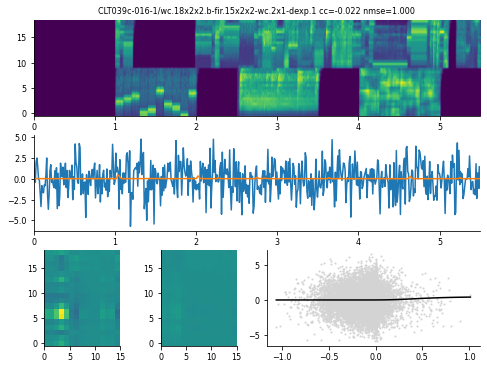

In [187]:
plot_binaural_model(model_sci, X_val, Y_val=Y_val)

Now reinitialize and fit again

In [80]:
model = Model.from_keywords(modelspec)
model = model.sample_from_priors();


In [81]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 dexp (StaticNonlinearityTF)  (None, 50000, 1)         4         
                                                                 
Total params: 138
Trainable params: 135
Non-trainable params: 3
______________________________________

1/1 [==============================] - 0s 13ms/step - loss: 0.9977
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9960
Epoch 62/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.9947
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9937
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9931
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9927
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9924
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9922
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9919
Epoch 69/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9917
Epoch 70/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9913
Epoch 71/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9909
Epoch 72/2000
1/1 [=======================

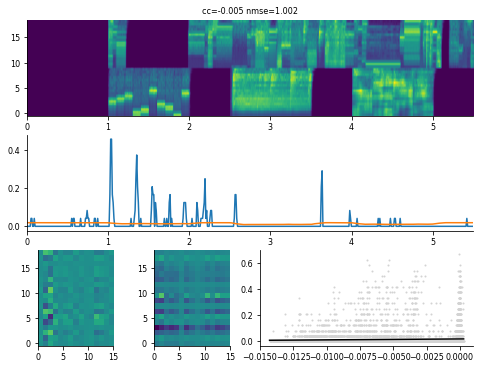

In [82]:
plot_binaural_model(model, X_val, Y_val=Y_val)

In [17]:
x1=model.predict(X_est)
x1.shape

(50000, 1)

In [18]:
x2=model.backend.predict(np.expand_dims(X_est, axis=0))[0,:,:]
x2.shape

(50000, 1)

In [13]:
np.corrcoef(x1[:,0],x2[:,0])

array([[1.        , 0.99982959],
       [0.99982959, 1.        ]])

In [19]:
np.corrcoef(x1[:,0],Y_est[:,0])

array([[ 1.        , -0.29751566],
       [-0.29751566,  1.        ]])

In [17]:
reps=15
cc=np.zeros(reps)
nmse=np.zeros(reps)

for i in range(reps):
    model = Model.from_keywords(modelspec)
    model = model.sample_from_priors();
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

    # Trying a TF fit:
    model.layers[-1].skip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)

    model.layers[-1].unskip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    cc[i] = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y_val) / np.std(Y_val)
        

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (StaticNonlinearityTF)  (None, 50000, 1)         3         
                                                                 
Total params: 137
Trainable params: 135
Non-trainable params: 2
______________________________________

1/1 [==============================] - 0s 13ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 69/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 70/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 71/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 72/2000
1/1 [=======================

Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8095
Epoch 79/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8095
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8094
Epoch 81/2000
1/1 [=========

1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 21ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8166
Epoch 151/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8164
Epoch 152/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8162
Epoch 153/2000
1/1 [===========

1/1 [==============================] - 0s 13ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 20ms/step - loss: 0.8415
Epoch 31/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 32/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8423
Epoch 33/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8431
Epoch 34/2000
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8196
Epoch 132/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8193
Epoch 133/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8190
Epoch 134/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8188
Epoch 135/2000
1/1 [===========

Epoch 4/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.0406
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0005
Epoch 6/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.9617
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9273
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8786
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8650
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8577
Epoch 12/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8555
Epoch 13/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8569
Epoch 14/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8602
Epoch 15/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8641
Epoch 16/2000
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 0.8338
Epoch 106/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8334
Epoch 107/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8330
Epoch 108/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8326
Epoch 109/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8321
Epoch 110/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8316
Epoch 111/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8311
Epoch 112/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8306
Epoch 113/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8300
Epoch 114/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8294
Epoch 115/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8288
Epoch 116/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8281
Epoch 117/2000
1/1 [===========

Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (RectifiedLinearTF)    (None, 50000, 1)          3         
                                                                 
Total params: 137
Trainable params: 136
Non-trainable params: 1
__________

1/1 [==============================] - 0s 294ms/step - loss: 0.8773
Epoch 2/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8688
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8614
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8421
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8398
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8384
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================

1/1 [==============================] - 0s 14ms/step - loss: 0.8389
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8388
Epoch 77/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 78/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8387
Epoch 79/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8386
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 81/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 82/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8384
Epoch 83/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 84/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 87/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 85/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 86/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 88/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8091
Epoch 89/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 91/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 92/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8089
Epoch 95/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8089
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8403
Epoch 58/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8399
Epoch 60/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 69/2000
1/1 [=======================

Epoch 66/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8102
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [=========

1/1 [==============================] - 0s 14ms/step - loss: 0.8181
Epoch 139/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8180
Epoch 140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8179
Epoch 141/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [===========

1/1 [==============================] - 0s 13ms/step - loss: 0.8704
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8685
Epoch 21/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8655
Epoch 22/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8415
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8255
Epoch 121/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8248
Epoch 122/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 123/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8196
Epoch 132/2000
1/1 [===========

Epoch 1/2000
1/1 [==============================] - 0s 322ms/step - loss: 1.1471
Epoch 2/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1152
Epoch 3/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0794
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0406
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0005
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9617
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9273
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8786
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8650
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8577
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8555
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8385
Epoch 14/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 15/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8393
Epoch 16/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8393
Epoch 17/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 18/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 19/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8371
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8355
Epoch 21/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8336
Epoch 22/2000
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.8086
Epoch 112/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8086
Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (RectifiedLinearTF)    (None, 50000, 1)          3 

1/1 [==============================] - 0s 12ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8380
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8379
Epoch 88/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8377
Epoch 89/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8376
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8374
Epoch 91/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8373
Epoch 92/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8371
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8370
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8368
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8366
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 294ms/step - loss: 0.8773
Epoch 2/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8688
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8614
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8421
Epoch 8/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8398
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8384
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================]

1/1 [==============================] - 0s 12ms/step - loss: 0.8389
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8388
Epoch 77/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 78/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8387
Epoch 79/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8386
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 81/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8385
Epoch 82/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8384
Epoch 83/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 84/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 87/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8092
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8092
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 88/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 89/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 91/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 92/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 94/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8089
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8089
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8403
Epoch 58/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8399
Epoch 60/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8394
Epoch 69/2000
1/1 [=======================

Epoch 66/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8102
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [=========

1/1 [==============================] - 0s 12ms/step - loss: 0.8181
Epoch 139/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8180
Epoch 140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8179
Epoch 141/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [===========

1/1 [==============================] - 0s 12ms/step - loss: 0.8704
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8685
Epoch 21/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8655
Epoch 22/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8415
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8255
Epoch 121/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8248
Epoch 122/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 123/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8196
Epoch 132/2000
1/1 [===========

In [18]:
cc,nmse

(array([0.50333618, 0.50333621, 0.50333622, 0.5033362 , 0.5033362 ,
        0.50333617, 0.50333622, 0.50333621, 0.50333621, 0.50333622,
        0.50333617, 0.50333619, 0.50333618, 0.50333621, 0.5033362 ]),
 array([0.86485837, 0.86485836, 0.86485835, 0.86485836, 0.86485836,
        0.86485838, 0.86485835, 0.86485836, 0.86485836, 0.86485835,
        0.86485837, 0.86485837, 0.86485837, 0.86485836, 0.86485836]))

In [19]:
!hostname

manatee


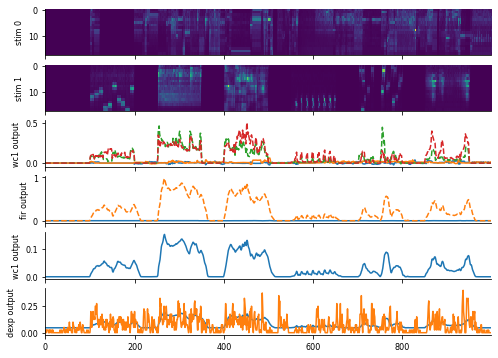

In [21]:
plot_binaural_layers(model, X_val, Y_val=Y_val)

Fit with scipy backend

In [ ]:
print('Fitting without NL ...')
model.layers[-1].skip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00000001, 'maxiter': 50}})

print('Now fitting with NL ...')
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.000000001, 'maxiter': 100}})

Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00072953...


Test that model does what it's supposed to do with each coefficient

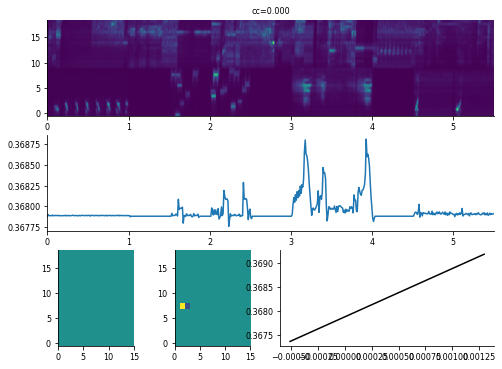

In [5]:
model = Model.from_keywords(modelspec)

wc = model.layers[0]['coefficients'].values
wc[:]=0
wc[7,1,1]=1
model.layers[0]['coefficients'] = wc

fir = model.layers[1]['coefficients'].values
fir[:]=0
fir[1,1,1]=0.5
fir[2,1,1]=-0.25
model.layers[1]['coefficients'] = fir

wc2 = model.layers[2]['coefficients'].values
wc2[0] = 1
model.layers[2]['coefficients'] = wc2

#print(model.layers[3]['shift'].values, model.layers[3]['offset'].values, model.layers[3]['gain'].values)

plot_binaural_model(model, X_val, Y_val=None)
#plot_binaural_layers(model, X_val, Y_val=None)